# Blockface WildCat Training Notebook

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB


In [4]:
# Import wildcat
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

In [6]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/home/pyushkevich/data/bf/exp01"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for
num_epochs = 30

# Input image size
input_size = 128

In [7]:
# Or use their initialization method
model=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.02, kmin=0.0, alpha=0.7, num_maps=1)
# model=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.05, kmin=0.02, alpha=0.5, num_maps=2)

In [8]:
# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(90),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [9]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [10]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], 2])
                labels_one_hot[:,0] = (labels==0)
                labels_one_hot[:,1] = (labels==1)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history




In [11]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=30)





Epoch 0/29
----------


/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


train Loss: 0.6611 Acc: 0.7480
val Loss: 0.6905 Acc: 0.4958

Epoch 1/29
----------
train Loss: 0.4816 Acc: 0.9000
val Loss: 0.6781 Acc: 0.8056

Epoch 2/29
----------
train Loss: 0.3683 Acc: 0.9314
val Loss: 0.5676 Acc: 0.8930

Epoch 3/29
----------
train Loss: 0.2911 Acc: 0.9549
val Loss: 0.3786 Acc: 0.9296

Epoch 4/29
----------
train Loss: 0.2444 Acc: 0.9510
val Loss: 0.2857 Acc: 0.9408

Epoch 5/29
----------
train Loss: 0.1926 Acc: 0.9569
val Loss: 0.2652 Acc: 0.9437

Epoch 6/29
----------
train Loss: 0.1695 Acc: 0.9578
val Loss: 0.2418 Acc: 0.9437

Epoch 7/29
----------
train Loss: 0.1337 Acc: 0.9725
val Loss: 0.2383 Acc: 0.9296

Epoch 8/29
----------
train Loss: 0.1123 Acc: 0.9755
val Loss: 0.1625 Acc: 0.9718

Epoch 9/29
----------
train Loss: 0.1002 Acc: 0.9804
val Loss: 0.1500 Acc: 0.9634

Epoch 10/29
----------
train Loss: 0.0805 Acc: 0.9863
val Loss: 0.1396 Acc: 0.9775

Epoch 11/29
----------
train Loss: 0.0817 Acc: 0.9833
val Loss: 0.1541 Acc: 0.9606

Epoch 12/29
----------
t

In [13]:
model_dir="/home/pyushkevich/resnet/bf_wcat/exp01/"
os.makedirs(model_dir, exist_ok=True)
torch.save(model_ft.state_dict(),os.path.join(model_dir, "bf_wcat_50_30epoch_k02_upsample_1map.dat"))

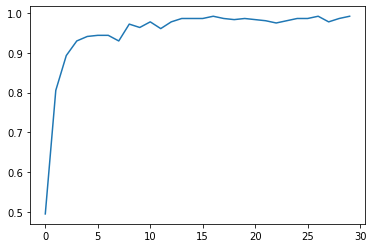

In [14]:
plt.plot(hist)

In [ ]:
del model_ft
torch.cuda.empty_cache()

In [1]:
!nvidia-smi

Wed Apr  8 14:53:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  